# Full ion stats on one example dataset

This notebook calculates all pairwise delta m/z within an RT window.

Use `ST001237_HILICpos_B2_ppm5_3524314` as example.


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from khipu.utils import peaks_to_networks

sys.path.insert(0, '..')
from mining import * 

ST001237 = 'ST001237_HILICpos_B2_ppm5_3524314'
json_epds = f'{ST001237}/ecpds.json'
ftable = f'{ST001237}/preferred_feature_table.tsv'
stdev_shift = 0.613 # pre-calculated. See get_isotope_elution_window


In [7]:
num_samples, featureList = read_features_from_asari_table(open(ftable).read())

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', '1120a_Marios_PD1_Inhib2_HP-PREFA58', '1040_Marios_PD1_Inhib2_HP-EA717425-8', '1040a_Marios_PD1_Inhib2_HP-PREFA54', '1040b_Marios_PD1_Inhib2_HP-PREFB54', '1041_Marios_PD1_Inhib2_HP-E9133655-7', '1042_Marios_PD1_Inhib2_HP-L1376088-6', '1043_Marios_PD1_Inhib2_HP-L1305560-7', '1044_Marios_PD1_Inhib2_HP-L1370589-6', '1045_Marios_PD1_Inhib2_HP-E9123619-6']
Read 20119 feature lines


In [5]:
# Basic khipu construction
subnetworks, peak_dict, _ = peaks_to_networks(featureList, 
                         isotope_search_patterns=[(1.003355, '13C/12C', (0, 0.8)), (2.00671, '13C/12C*2', (0, 0.8)),],
                        adduct_search_patterns=[(21.982, 'Na/H')], 
                        mz_tolerance_ppm=5, 
                        rt_tolerance=2*stdev_shift)
len(subnetworks)

5163

In [4]:
list(subnetworks[99].nodes())

['F4305', 'F6583', 'F9907']

In [5]:
sum([n.number_of_nodes() for n in subnetworks])

6702

The example dataset has 20119 features, of which 2739 khipus are found.

In [43]:
_lf, f2epd, epd_summary = epd2featurelist_from_file(json_epds, mode='pos')

In [46]:
good_khipus = epd_summary['good_khipus']
len(good_khipus)

2893

In [44]:
help(epd2featurelist_from_file)

Help on function epd2featurelist_from_file in module mining:

epd2featurelist_from_file(file, mode='pos', snr=5, shape=0.9)
    returns list_features, feature2epd_dict, epd_summary



In [47]:
good_khipus[88]['neutral_formula_mass']

72.07769603323

In [49]:
# Bin khipus by RT
rtBins = []
for kp in good_khipus:
    rt = np.mean([f['rtime'] for f in kp['MS1_pseudo_Spectra']])
    rtBins.append(
        {
            'id': kp['interim_id'],
            'rtime': rt,
        'mw': kp['neutral_formula_mass']}
    )

In [50]:
# get lists of delta mw
mw_delta_dict = {}
for kp in rtBins:
    _in_bin = [x for x in rtBins if x['mw']<kp['mw'] and abs(x['rtime']-kp['rtime']) < stdev_shift]
    mw_delta_dict[kp['id']] = [kp['mw']-x['mw'] for x in _in_bin]

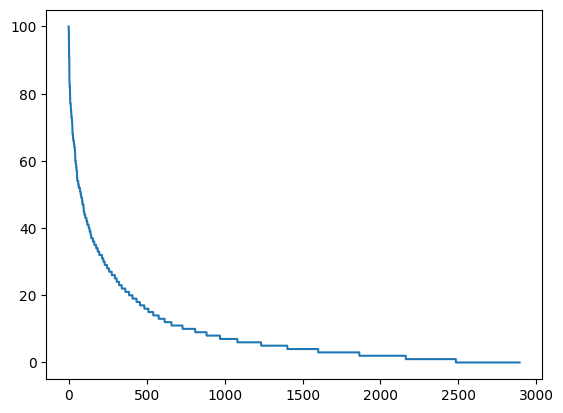

In [52]:
num_deltas = sorted([len(v) for v in mw_delta_dict.values()], reverse=True)
plt.plot(range(len(num_deltas)), num_deltas)

In [56]:
counts = []
for v in mw_delta_dict.values():
    counts += [str(round(x, 3)) for x in v]
    
len(counts), len(set(counts))

(26915, 21001)

In [57]:
_u = set(counts)
_c = sorted([(counts.count(ii), ii) for ii in _u], reverse=True)
_c[:20]

[(60, '14.016'),
 (59, '28.031'),
 (59, '18.011'),
 (54, '2.016'),
 (41, '26.016'),
 (40, '15.995'),
 (37, '2.015'),
 (37, '12.0'),
 (30, '44.026'),
 (30, '18.01'),
 (29, '58.042'),
 (23, '42.011'),
 (23, '20.026'),
 (22, '32.026'),
 (22, '3.995'),
 (22, '17.027'),
 (21, '67.988'),
 (20, '24.0'),
 (19, '60.021'),
 (19, '46.042')]

In [7]:
from itertools import combinations
from scipy.signal import find_peaks 
import statsmodels.api as sm

In [8]:
# This took ~20 secs
mzdeltas = []
for a, b in combinations(peak_dict.values(), 2):
    if abs(a['rtime'] - b['rtime']) < stdev_shift:
        mzdeltas.append(abs(a['mz'] - b['mz']))
        
len(mzdeltas)

1166018

In [16]:
# No need for too small numbers
mzdeltas = [x for x in mzdeltas if x > 0.3]
mzdeltas = sorted(mzdeltas)
len(mzdeltas), len([x for x in mzdeltas if x < 25])

(1159597, 131337)

In [18]:
mzdeltas[131337-5: 131337 + 5]

[24.999599999999987,
 24.99969999999996,
 24.99970000000002,
 24.999799999999993,
 24.999799999999993,
 25.0,
 25.000099999999975,
 25.000200000000007,
 25.000699999999995,
 25.000699999999995]

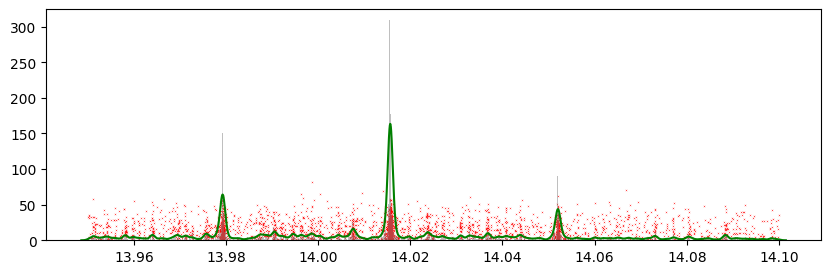

In [42]:
mzample = [x for x in mzdeltas if 13.95 < x < 14.1]
NN = len(mzample)

bandwidth = 0.0005   
bins = 1000

xx = np.array(mzample[:NN])

kde = sm.nonparametric.KDEUnivariate(xx)
kde.fit(bw=bandwidth) 

yy = np.abs(np.random.randn(NN)) * 20

plt.figure(figsize=(10,3))
plt.scatter(xx, yy, marker="x", c='r', s=.02 )
plt.hist(xx, bins=bins, color='grey', alpha=.5)

plt.plot(kde.support, kde.density, 'g-')
plt.savefig('kdeplot_test.pdf')

In [36]:
def get_kde_peaks(x_kde_support, y_kde_density, 
                  height=0.5,
                  distance=10,
                  prominence=0.25,
                  width=10,
                  wlen=200,
                  ):
    '''
    Find peaks in KDE density.
    Returns list [(m/z peak, kde density), ...]
    
    We fit KDE with bandwith of 1 ppm.
    
    distance : 10, # about 1 ppm on this dataset
    prominence : half of min height
    wlen : about 20 ppm
    '''
    peaks, properties = find_peaks(y_kde_density, 
                                    height=height, 
                                    distance=distance,
                                    prominence=prominence,
                                    width=width, 
                                    wlen=wlen,
                                    ) 
    real_apexes = [x_kde_support[ii] for ii in peaks]
    return list(zip(real_apexes, properties['peak_heights']))

def get_kde_from_deltamz(mzdata, 
                         bandwidth=0.005, threshold=0.01):
    kde = sm.nonparametric.KDEUnivariate(mzdata)
    kde.fit(bw=bandwidth) 
    prominence = 0.5 * threshold
    peaks_density = get_kde_peaks(kde.support, kde.density, height=threshold, 
                                        prominence=prominence,
                                        )
    
    print(len(mzdata), kde.support.shape[0], threshold, len(peaks_density))
    return peaks_density

In [37]:
peaks_density = get_kde_from_deltamz(mzdeltas)

1159597 2097152 0.01 206


In [38]:
peaks_density = sorted(peaks_density, key=lambda x: x[1], reverse=True)

In [39]:
peaks_density[:20]

[(1.0034232731453723, 0.23813859898120665),
 (2.014847475265296, 0.10117279890326034),
 (14.01564423029152, 0.07502424459409242),
 (28.031292567058877, 0.0725612937165368),
 (21.982565566618756, 0.07029622854104131),
 (18.01057860030112, 0.07015826137356357),
 (26.01574560944829, 0.060945095379209904),
 (17.02696943295933, 0.05349152896140946),
 (3.0182748548865055, 0.05252160685851626),
 (12.000097272680932, 0.04946629394337567),
 (67.9875900258494, 0.049172996146435624),
 (15.995031642690531, 0.04880284173019087),
 (23.999850963902976, 0.04553899497316034),
 (16.02875737235902, 0.045230472783631306),
 (20.980181250801724, 0.04293834206176014),
 (15.017333170239096, 0.041772804381557005),
 (44.026328316225246, 0.04097860393905706),
 (30.046839524669466, 0.04073640881824766),
 (4.031089808745336, 0.04065840825861511),
 (54.04704228298301, 0.04041126908444845)]

In [40]:
s = 'mz\tkde\n'
for x in peaks_density:
    s += str(round(x[0], 4)) + '\t' + str(round(x[1], 4)) + '\n'
with open('KDE_' + ST001237 + '.tsv', 'w') as O:
    O.write(s)

# Conclusion

- We have calculated 206 most frequent delta m/z values in one example dataset, ST001237.
- Result saved to tsv.

However, KDE is hard to automate. We'll use a simplified and faster method to calculate delta to good khipus, since ion patterns are more reliable on more abundant features.